# Evaluate ALL features

Similar to notebook 3 but we package everything inside a for loop to evaluate all the features.

In [1]:
# TO REMOVE when notebook is stable

%load_ext autoreload
%autoreload 2

### Common Imports

In [2]:
import numpy
import torch
import seaborn
import tarfile
import os
import matplotlib
import matplotlib.pyplot as plt
from anndata import read_h5ad

# tissue_purifier import
import tissue_purifier as tp

### Download the annotated anndata object 

Altenatively you can use the anndata files generated by running notebook2_all.

In [3]:
import tissue_purifier.io

bucket_name = "ld-data-bucket"
annotated_anndata_source_path = "tissue-purifier/annotated_slideseq_testis_anndata_h5ad.tar.gz"
annotated_anndata_dest_path = "./annotated_slideseq_testis_anndata_h5ad.tar.gz"
annotated_anndata_dest_folder = "./testis_anndata_annotated"

#tp.io.download_from_bucket(bucket_name, annotated_anndata_source_path, annotated_anndata_dest_path)   
#with tarfile.open(annotated_anndata_dest_path, "r:gz") as fp:
#    fp.extractall(path=annotated_anndata_dest_folder)
    
# Make a list of all the h5ad files in the annotated_anndata_dest_folder
fname_list = []
for f in os.listdir(annotated_anndata_dest_folder):
    if f.endswith('.h5ad'):
        fname_list.append(f)
print(fname_list)

['anndata_sick3.h5ad', 'anndata_sick1.h5ad', 'anndata_sick2.h5ad', 'anndata_wt2.h5ad', 'anndata_wt1.h5ad', 'anndata_wt3.h5ad']


### Decide how to filter the anndata object

In [4]:
# filter cells parameters
fc_bc_min_umi = 200                  # filter cells with too few UMI
fc_bc_max_umi = 3000                 # filter cells with too many UMI
fc_bc_min_n_genes_by_counts = 10     # filter cells with too few GENES
fc_bc_max_n_genes_by_counts = 2500   # filter cells with too many GENES
fc_bc_max_pct_counts_mt = 5          # filter cells with mitocrondial fraction too high

# filter genes parameters
fg_bc_min_cells_by_counts = 3000      # filter genes which appear in too few CELLS

# filter rare cell types parameters
fctype_bc_min_cells_absolute = 100   # filter cell-types which are too RARE in absolute number
fctype_bc_min_cells_frequency = 0.01 # filter cell-types which are too RARE in relative abundance

### Open the first annotated anndata 

In [5]:
adata = read_h5ad(filename=os.path.join(annotated_anndata_dest_folder, fname_list[0]))
adata

AnnData object with n_obs × n_vars = 33441 × 23514
    obs: 'x', 'y', 'cell_type'
    obsm: 'barlow', 'dino', 'ncv_k10', 'ncv_k100', 'ncv_k20', 'ncv_k200', 'ncv_k50', 'ncv_k500', 'simclr', 'vae'

### compute few metrics

In [6]:
import scanpy as sc
cell_type_key = "cell_type"

# mitocondria metrics
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# counts cells frequency
tmp = adata.obs[cell_type_key].values.describe()
print(tmp)
mask1 = (tmp["counts"] > fctype_bc_min_cells_absolute)
mask2 = (tmp["freqs"] > fctype_bc_min_cells_frequency)
mask = mask1 * mask2
cell_type_keep = set(tmp[mask].index.values)
adata.obs["keep_ctype"] = adata.obs["cell_type"].apply(lambda x: x in cell_type_keep)

# Note that adata has extra annotation now
adata

             counts     freqs
categories                   
ES            12552  0.375348
Endothelial     417  0.012470
Leydig          340  0.010167
Macrophage      623  0.018630
Myoid           969  0.028976
RS             6780  0.202745
SPC            8069  0.241291
SPG            2238  0.066924
Sertoli        1453  0.043450


AnnData object with n_obs × n_vars = 33441 × 23514
    obs: 'x', 'y', 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'keep_ctype'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'barlow', 'dino', 'ncv_k10', 'ncv_k100', 'ncv_k20', 'ncv_k200', 'ncv_k50', 'ncv_k500', 'simclr', 'vae'

### Filter out cells, genes and cell-type

In [7]:
adata = adata[adata.obs["total_counts"] > fc_bc_min_umi, :] 
adata = adata[adata.obs["total_counts"] < fc_bc_max_umi, :] 
adata = adata[adata.obs["n_genes_by_counts"] > fc_bc_min_n_genes_by_counts, :] 
adata = adata[adata.obs["n_genes_by_counts"] < fc_bc_max_n_genes_by_counts, :] 
adata = adata[adata.obs["pct_counts_mt"] < fc_bc_max_pct_counts_mt, :]
adata = adata[adata.obs["keep_ctype"] == True, :]
adata = adata[:, adata.var["n_cells_by_counts"] > fg_bc_min_cells_by_counts]

# Loop to train multiple gene_regression models

In [8]:
from tissue_purifier.genex import *
gr_ckpt_dir = "gr_ckpt"
filename_no_covariate_ckpt = os.path.join(gr_ckpt_dir, "gr_no_covariate.pt")
filename_no_covariate_dataset = os.path.join(gr_ckpt_dir, "gr_no_covariate_dataset.pt")

# covariate_keys = ['barlow_pca', 'dino_pca', 'simclr_pca']
# covariate_keys = ['barlow', 'dino', 'simclr']
# covariate_keys = ['ncv_k10', 'ncv_k100', 'ncv_k20', 'ncv_k200', 'ncv_k50', 'ncv_k500']
covariate_keys = []

l1_strengths = [] #None, 10.0]
l2_strengths = [None, 10.0]

n_train_steps = 5000

gr = GeneRegression()
gr.configure_optimizer(optimizer_type='adam', lr=5E-4)

for n_iter, covariate_key in enumerate(covariate_keys):
    print(covariate_key)

    # decide the subsample size (to fit into GPU memory)
    if covariate_key.startswith("ncv") or covariate_key.endswith("_pca"):
        subsample_size_cells = 2000
    else:
        subsample_size_cells = 200 
        
    
    if covariate_key.endswith("_pca"):
        
        # make gene dataset with PCA
        gene_dataset = make_gene_dataset_from_anndata(
            anndata=adata,
            cell_type_key='cell_type',
            covariate_key=covariate_key.split("_")[0],
            preprocess_strategy='z_score',
            apply_pca=True,
            n_components=9,)
        
    else:
        
        # make the dataset without PCA
        gene_dataset = make_gene_dataset_from_anndata(
            anndata=adata,
            cell_type_key='cell_type',
            covariate_key=covariate_key,
            preprocess_strategy='raw',
            apply_pca=False)
    
    # split into train/test/val (note that we provide the random_state for reproducibility) 
    train_test_val_dataset = next(iter(train_test_val_split(gene_dataset, random_state=0)))
    filename_dataset = os.path.join(gr_ckpt_dir, "gr_{}_dataset.pt".format(covariate_key))
    torch.save(train_test_val_dataset, filename_dataset)
    train_dataset, test_dataset, val_dataset = train_test_val_dataset
    
    # only at the very beginning train a model with no_covariance and no_regularization from scratch
    if n_iter == 0:
        print("no covariate")
        gr.train(
            dataset=train_dataset,
            n_steps=n_train_steps,
            print_frequency=100,
            use_covariates=False,
            l1_regularization_strength=None,
            l2_regularization_strength=None,
            eps_range=(1.0E-5, 1.0E-1),
            subsample_size_cells=subsample_size_cells,
            subsample_size_genes=None,
            initialization_type="scratch")
        gr.save_ckpt(filename_no_covariate_ckpt)
        torch.save(train_test_val_dataset, filename_no_covariate_dataset)
        print("saved file {}".format(filename_no_covariate_ckpt))
        print("saved file {}".format(filename_no_covariate_dataset))
    
    # train with regularization.
    for n, l in enumerate(l1_strengths + l2_strengths):
        if n < len(l1_strengths):
            l1 = l
            l2 = None
            filename = os.path.join(gr_ckpt_dir, "gr_{}_l1_{}.pt".format(covariate_key, l1))
        else:
            l1 = None
            l2 = l
            filename = os.path.join(gr_ckpt_dir, "gr_{}_l2_{}.pt".format(covariate_key, l2))
    
        gr.train(
            dataset=train_dataset,
            n_steps=n_train_steps,
            print_frequency=100,
            use_covariates=True,
            l1_regularization_strength=l1,
            l2_regularization_strength=l2,
            eps_range=(1.0E-5, 1.0E-1),
            subsample_size_cells=subsample_size_cells,
            subsample_size_genes=None,
            initialization_type="scratch")
        gr.save_ckpt(filename)
        print("saved file {}".format(filename))

# compare all regression 

get the name of all the files in the ckpt_dir

In [9]:
ckpt_list = []
for f in os.listdir(gr_ckpt_dir):
    if not f.endswith("dataset.pt"):
        ckpt_list.append(f)

In [18]:
dataset_list = []
for ckpt in ckpt_list:
    tmp = ckpt.split("_")
    if len(tmp) == 5:
        dataset_file = tmp[0]+"_"+tmp[1]+"_"+tmp[2]+"_dataset.pt"
    elif len(tmp) == 4:
        dataset_file = tmp[0]+"_"+tmp[1]+"_dataset.pt"
    elif len(tmp) == 3:
        dataset_file = tmp[0]+"_"+tmp[1]+"_covariate_dataset.pt"
    dataset_list.append(dataset_file)
    print("{} --> {}".format(ckpt, dataset_file))

gr_ncv_k50_l2_10.0.pt --> gr_ncv_k50_dataset.pt
gr_barlow_l2_10.0.pt --> gr_barlow_dataset.pt
gr_ncv_k50_l2_None.pt --> gr_ncv_k50_dataset.pt
gr_ncv_k500_l2_None.pt --> gr_ncv_k500_dataset.pt
gr_ncv_k10_l2_10.0.pt --> gr_ncv_k10_dataset.pt
gr_simclr_l2_None.pt --> gr_simclr_dataset.pt
gr_dino_l2_None.pt --> gr_dino_dataset.pt
gr_simclr_l2_10.0.pt --> gr_simclr_dataset.pt
gr_ncv_k100_l2_None.pt --> gr_ncv_k100_dataset.pt
gr_ncv_k500_l2_10.0.pt --> gr_ncv_k500_dataset.pt
gr_no_covariate.pt --> gr_no_covariate_dataset.pt
gr_ncv_k10_l2_None.pt --> gr_ncv_k10_dataset.pt
gr_ncv_k20_l2_None.pt --> gr_ncv_k20_dataset.pt
gr_ncv_k20_l2_10.0.pt --> gr_ncv_k20_dataset.pt
gr_ncv_k200_l2_None.pt --> gr_ncv_k200_dataset.pt
gr_ncv_k100_l2_10.0.pt --> gr_ncv_k100_dataset.pt
gr_ncv_k200_l2_10.0.pt --> gr_ncv_k200_dataset.pt
gr_dino_l2_10.0.pt --> gr_dino_dataset.pt
gr_barlow_l2_None.pt --> gr_barlow_dataset.pt


### loss history

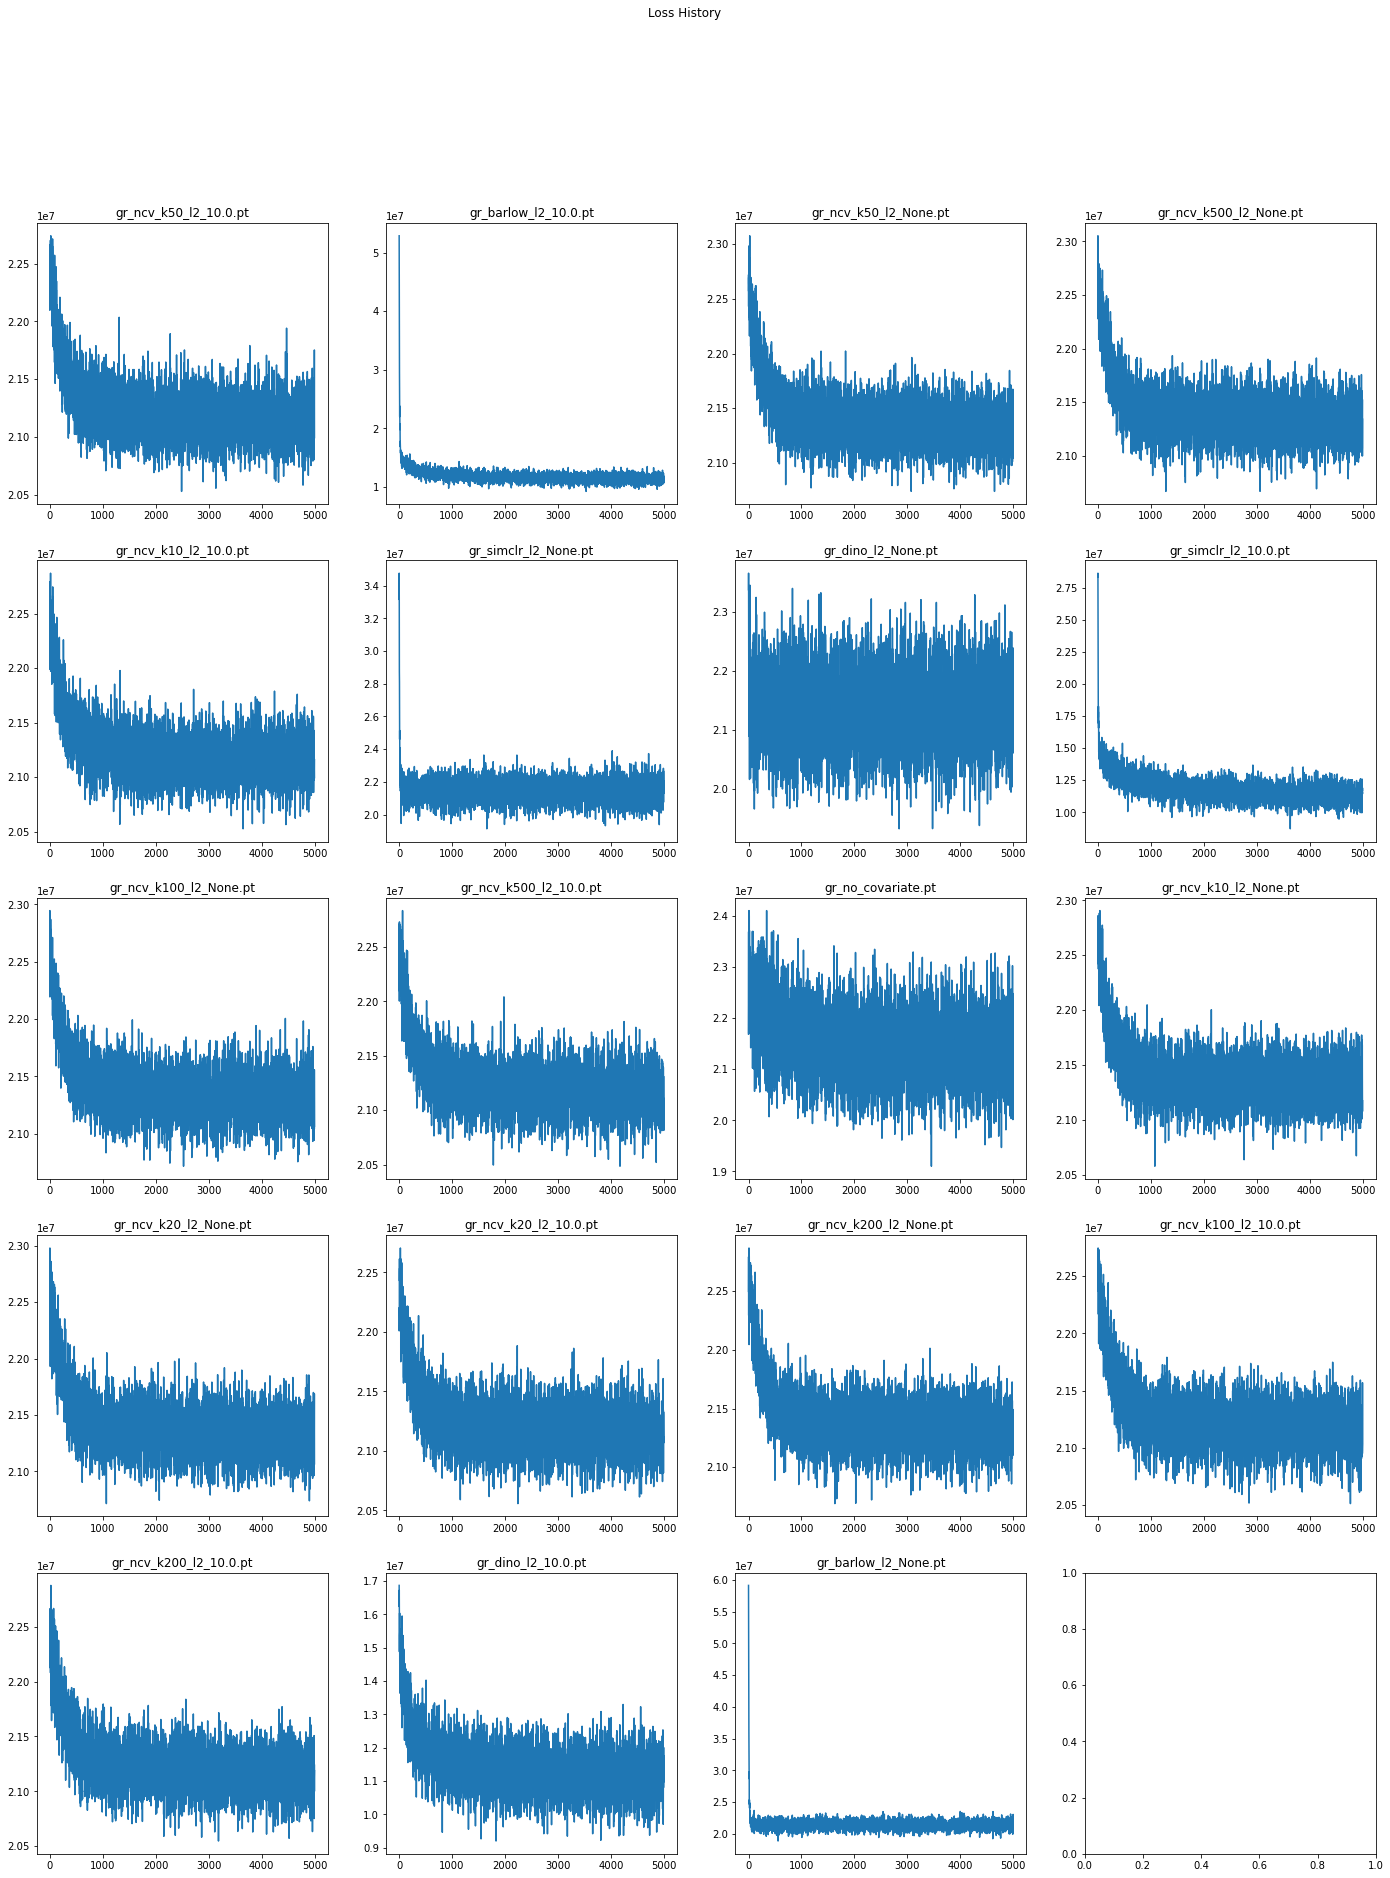

In [11]:
nmax = len(ckpt_list)
ncols = 4
nrows = int(numpy.ceil(float(nmax)/ncols))

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols, 6*nrows))
fig.suptitle("Loss History")

for n, ckpt_file in enumerate(ckpt_list):
    r,c = n//ncols, n%ncols
    ax_cur = axes[r,c]
    gr.load_ckpt(os.path.join(gr_ckpt_dir, ckpt_file))
    gr.show_loss(ax=ax_cur, logy=False, logx=False)
    _ = ax_cur.set_title(ckpt_file)

## check over-dispersion parameter

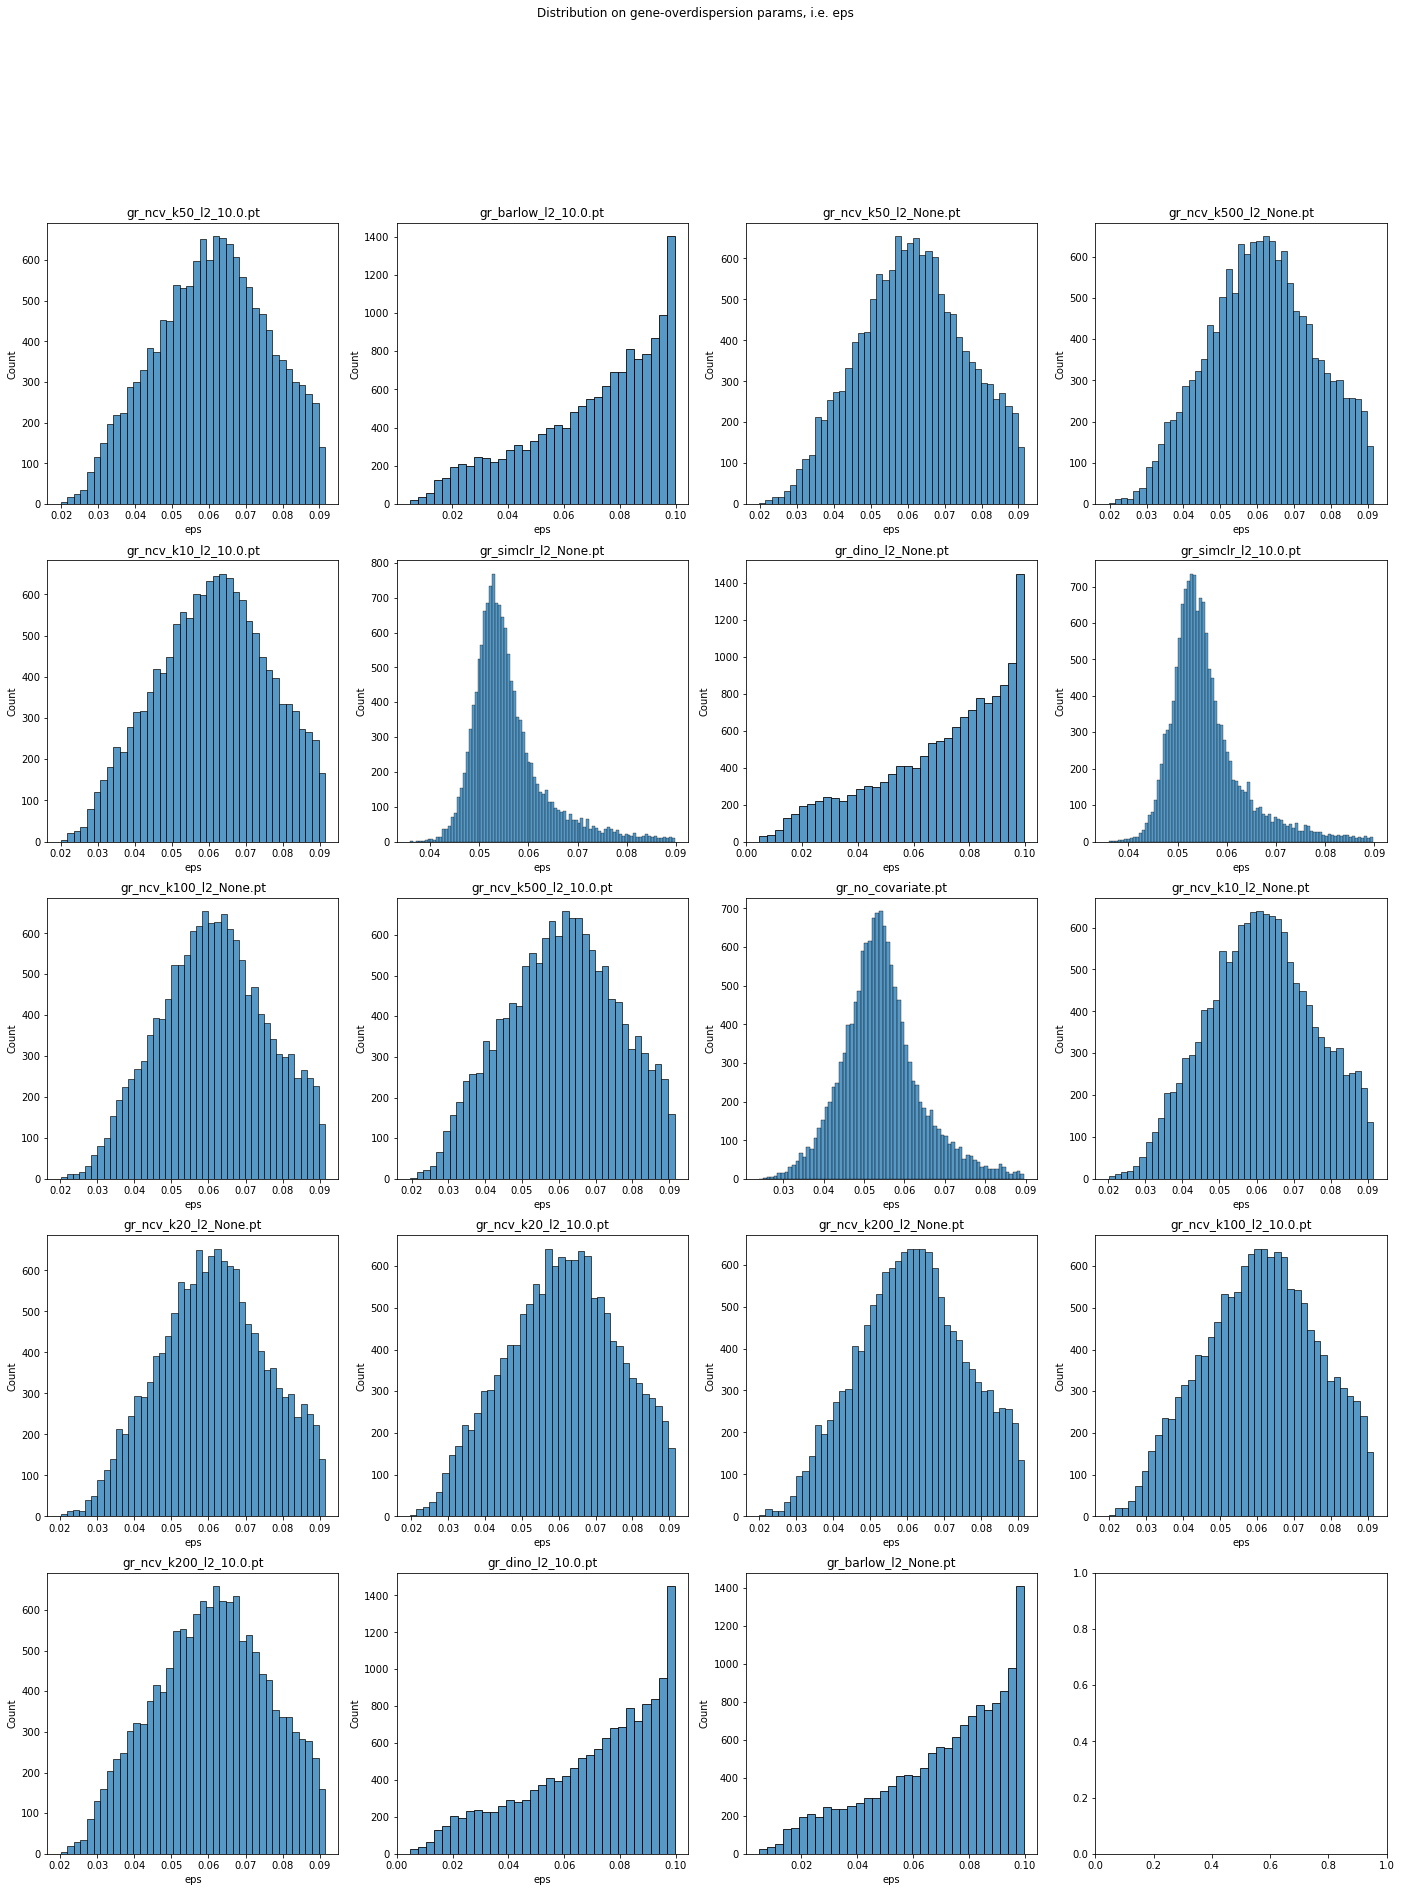

In [12]:
nmax = len(ckpt_list)
ncols = 4
nrows = int(numpy.ceil(float(nmax)/ncols))

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols, 6*nrows))
fig.suptitle("Distribution on gene-overdispersion params, i.e. eps")

for n, ckpt_file in enumerate(ckpt_list):
    r,c = n//ncols, n%ncols
    ax_cur = axes[r,c]
    gr.load_ckpt(os.path.join(gr_ckpt_dir, ckpt_file))
    df_param = gr.get_params()
    
    # _ = seaborn.histplot(data=df_param, x="eps", hue="cell_type", bins=200, ax=ax_cur, multiple="layer")
    _ = seaborn.histplot(data=df_param, x="eps", ax=ax_cur)
    _ = ax_cur.set_title(ckpt_file)

Investigate why the shapes are so different. \
Simclr and no-covariate are similar. \
Check the gene distribution (0observed vs predicted) for few genes. Like the one with fey high/low overdispersion. 

### Compute the baseline metrics (i.e. the case with no covariates).

In [14]:
gr.load_ckpt(filename_no_covariate_ckpt)
train_dataset, test_dataset, val_dataset = torch.load(filename_no_covariate_dataset)

#df_metric_no_cov_train, df_count_no_cov_train = gr.predict(
#    test_dataset,
#    num_samples=100,
#    subsample_size_cells=200,
#    subsample_size_genes=None)
# df_baseline_train = df_metric_no_cov_train.groupby(["cell_type", "gene"]).mean()

df_metric_no_cov_test, df_count_no_cov_test = gr.predict(
    test_dataset,
    num_samples=100,
    subsample_size_cells=200,
    subsample_size_genes=None)

df_baseline_test = df_metric_no_cov_test.groupby(["cell_type", "gene"]).mean() 

### compute the Q ratio w.r.t the no_covariate baseline 

In [19]:
result_dict = dict()

for n, (data_file, ckpt_file) in enumerate(zip(dataset_list, ckpt_list)):
    print(n, data_file, ckpt_file)

    gr.load_ckpt(os.path.join(gr_ckpt_dir, ckpt_file))
    train_dataset, test_dataset, _ = torch.load(os.path.join(gr_ckpt_dir, data_file))
    
    #df_metric_tmp_train, df_count_tmp_train = gr.predict(
    #    train_dataset,
    #    num_samples=100,
    #    subsample_size_cells=200,
    #    subsample_size_genes=None)
    
    # df_tmp_train = df_metric_tmp_train.groupby(["cell_type", "gene"]).mean()
    # df_tmp_train["q_ratio"] = df_tmp_train["q_dist"] / df_baseline_train["q_dist"]
    # result_dict["train_"+ckpt_file] = df_tmp_train["q_ratio"].values  
    
    df_metric_tmp_test, df_count_tmp_test = gr.predict(
        test_dataset,
        num_samples=100,
        subsample_size_cells=200,
        subsample_size_genes=None)
    
    df_tmp_test = df_metric_tmp_test.groupby(["cell_type", "gene"]).mean()
    df_tmp_test["q_ratio"] = df_tmp_test["q_dist"] / df_baseline_test["q_dist"]
    result_dict["test_"+ckpt_file] = df_tmp_test["q_ratio"].values 

0 gr_ncv_k50_dataset.pt gr_ncv_k50_l2_10.0.pt
1 gr_barlow_dataset.pt gr_barlow_l2_10.0.pt
2 gr_ncv_k50_dataset.pt gr_ncv_k50_l2_None.pt
3 gr_ncv_k500_dataset.pt gr_ncv_k500_l2_None.pt
4 gr_ncv_k10_dataset.pt gr_ncv_k10_l2_10.0.pt
5 gr_simclr_dataset.pt gr_simclr_l2_None.pt
6 gr_dino_dataset.pt gr_dino_l2_None.pt
7 gr_simclr_dataset.pt gr_simclr_l2_10.0.pt
8 gr_ncv_k100_dataset.pt gr_ncv_k100_l2_None.pt
9 gr_ncv_k500_dataset.pt gr_ncv_k500_l2_10.0.pt
10 gr_no_covariate_dataset.pt gr_no_covariate.pt
11 gr_ncv_k10_dataset.pt gr_ncv_k10_l2_None.pt
12 gr_ncv_k20_dataset.pt gr_ncv_k20_l2_None.pt
13 gr_ncv_k20_dataset.pt gr_ncv_k20_l2_10.0.pt
14 gr_ncv_k200_dataset.pt gr_ncv_k200_l2_None.pt
15 gr_ncv_k100_dataset.pt gr_ncv_k100_l2_10.0.pt
16 gr_ncv_k200_dataset.pt gr_ncv_k200_l2_10.0.pt
17 gr_dino_dataset.pt gr_dino_l2_10.0.pt
18 gr_barlow_dataset.pt gr_barlow_l2_None.pt


# Plot the distribution of the Q_ratio

In [21]:
result_dict

{'test_gr_ncv_k50_l2_10.0.pt': array([1.0323658 , 0.28107268, 1.0524336 , ..., 1.1530824 , 0.2979699 ,
        0.778222  ], dtype=float32),
 'test_gr_barlow_l2_10.0.pt': array([1.0112162 , 0.29059076, 1.3052715 , ..., 1.4760386 , 0.3028192 ,
        1.1696329 ], dtype=float32),
 'test_gr_ncv_k50_l2_None.pt': array([1.0492498 , 0.2727181 , 1.0426762 , ..., 1.1828655 , 0.29360548,
        0.7907317 ], dtype=float32),
 'test_gr_ncv_k500_l2_None.pt': array([1.0195388 , 0.27009618, 1.0801878 , ..., 1.2192669 , 0.319836  ,
        0.81897527], dtype=float32),
 'test_gr_ncv_k10_l2_10.0.pt': array([1.0261612 , 0.27818102, 1.0598109 , ..., 1.1383748 , 0.2968898 ,
        0.7883243 ], dtype=float32),
 'test_gr_simclr_l2_None.pt': array([1.0126183 , 0.31643018, 1.2637397 , ..., 1.4061772 , 0.5156171 ,
        0.7544924 ], dtype=float32),
 'test_gr_dino_l2_None.pt': array([ 0.97342134,  0.29234427,  1.5124352 , ..., 30.51452   ,
         0.4188286 ,  2.7532887 ], dtype=float32),
 'test_gr_simclr_l

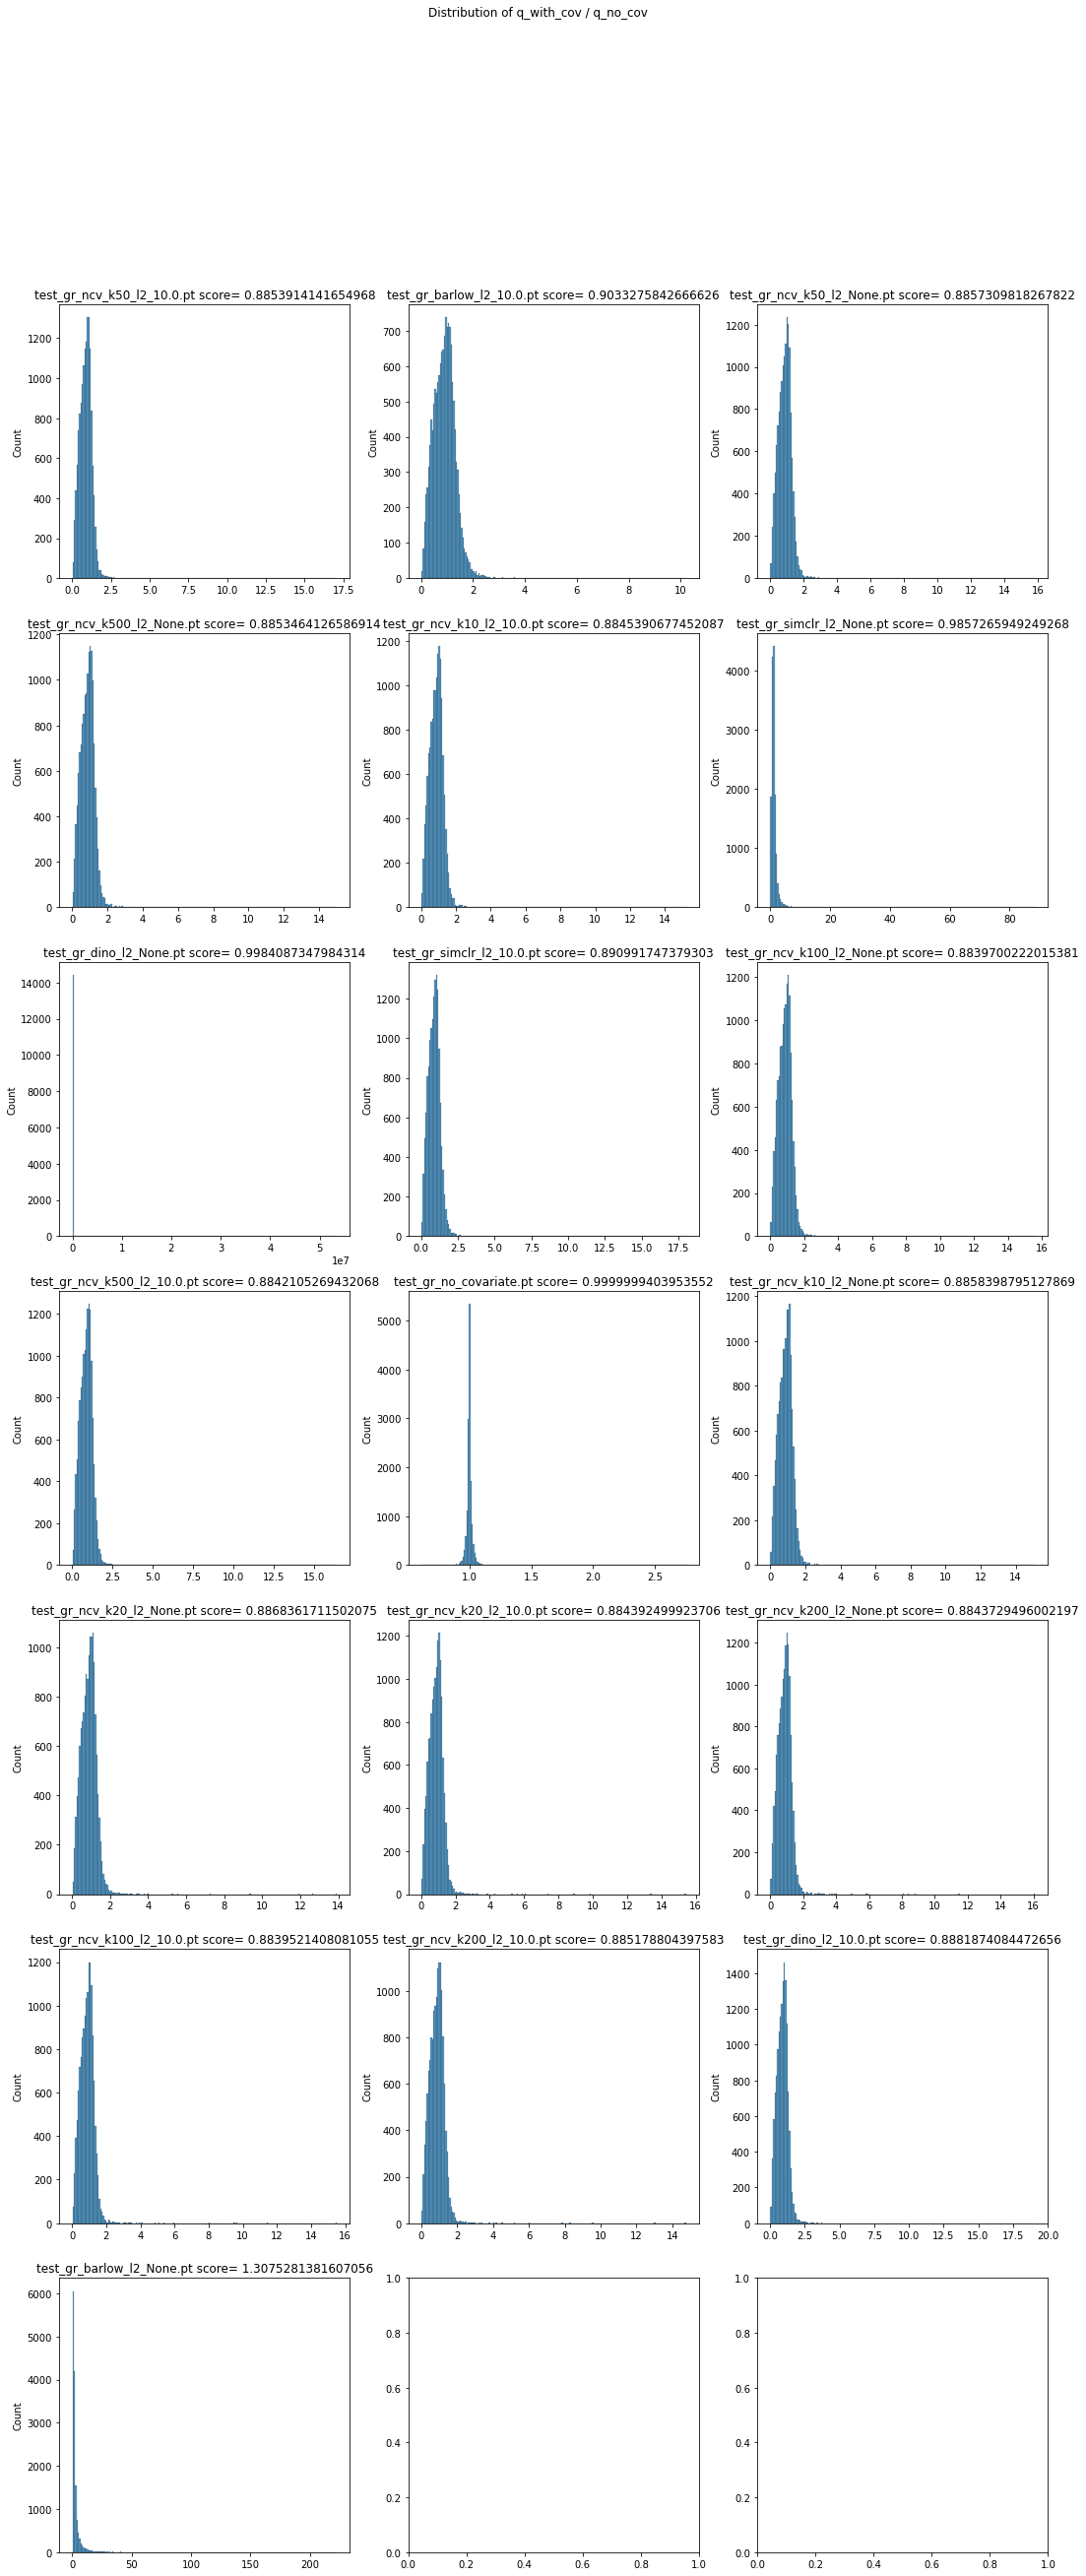

In [26]:
nmax = len(result_dict.keys())
ncols = 3
nrows = int(numpy.ceil(float(nmax)/ncols))

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols, 6*nrows))
fig.suptitle("Distribution of q_with_cov / q_no_cov")
    
score_dict = dict()
    
for n, key in enumerate(result_dict.keys()):
    r,c = n//ncols, n%ncols
    ax_cur = axes[r,c]
    _ = seaborn.histplot(x=result_dict[key], bins=200, ax=ax_cur)
    score = numpy.median(result_dict[key])
    score_dict[key] = score
    _ = ax_cur.set_title("{} score= {}".format(key, score))

# make plots vs length scale

In [27]:
score_dict

{'test_gr_ncv_k50_l2_10.0.pt': 0.8853914,
 'test_gr_barlow_l2_10.0.pt': 0.9033276,
 'test_gr_ncv_k50_l2_None.pt': 0.885731,
 'test_gr_ncv_k500_l2_None.pt': 0.8853464,
 'test_gr_ncv_k10_l2_10.0.pt': 0.88453907,
 'test_gr_simclr_l2_None.pt': 0.9857266,
 'test_gr_dino_l2_None.pt': 0.99840873,
 'test_gr_simclr_l2_10.0.pt': 0.89099175,
 'test_gr_ncv_k100_l2_None.pt': 0.88397,
 'test_gr_ncv_k500_l2_10.0.pt': 0.8842105,
 'test_gr_no_covariate.pt': 0.99999994,
 'test_gr_ncv_k10_l2_None.pt': 0.8858399,
 'test_gr_ncv_k20_l2_None.pt': 0.8868362,
 'test_gr_ncv_k20_l2_10.0.pt': 0.8843925,
 'test_gr_ncv_k200_l2_None.pt': 0.88437295,
 'test_gr_ncv_k100_l2_10.0.pt': 0.88395214,
 'test_gr_ncv_k200_l2_10.0.pt': 0.8851788,
 'test_gr_dino_l2_10.0.pt': 0.8881874,
 'test_gr_barlow_l2_None.pt': 1.3075281}